# Multivariate Testing (MVT)

- A/B testing compares two versions of a single change, but what if you want to test multiple changes at once? That’s where Multivariate Testing (MVT) comes in.

- Example Scenario:
    - Imagine testing a new website layout, where you’re experimenting with:
        - Button Color (Blue vs. Red)
        - Headline Text ("Buy Now" vs. "Get Started")
    - With A/B testing, you’d run separate tests for each, but MVT lets you test all combinations together.

## Designing a Multivariate Test
Let’s say we have:
- 2 button colors (Blue, Red)
- 2 headlines ("Buy Now", "Get Started")

Total variations:
- 2 × 2 = 4 combinations
  
Traffic Splitting
- With 100,000 visitors, each variation gets 25,000 visitors.

## Analyzing Multivariate Test Results
Multivariate testing typically uses:
- Chi-square tests (for conversion rates).
- Regression Models (to adjust for confounders).

## Multivariate Testing for affect on conversion rates

### Step 1: Simulating Multivariate Test Data

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency

# Simulate Data
np.random.seed(42)
n = 100000  # Total users

df = pd.DataFrame({
    'Button_Color': np.random.choice(['Blue', 'Red'], size=n),
    'Headline': np.random.choice(['Buy Now', 'Get Started'], size=n),
})

# Assign conversion rates based on variations
conversion_rates = {
    ('Blue', 'Buy Now'): 0.12,
    ('Blue', 'Get Started'): 0.14,
    ('Red', 'Buy Now'): 0.10,
    ('Red', 'Get Started'): 0.16
}

df['Converted'] = df.apply(lambda row: np.random.binomial(1, conversion_rates[(row['Button_Color'], row['Headline'])]), axis=1)
df.head()


,Button_Color,Headline,Converted
0,Blue,Buy Now,0
1,Red,Get Started,0
2,Blue,Get Started,0
3,Blue,Get Started,0
4,Blue,Get Started,0


### Step 2 (a): Chi-Square Test for Conversion Rate Differences

In [69]:
# Pivot table for chi-square test
pivot_table = pd.pivot_table(df, values='Converted', index='Button_Color', columns='Headline', aggfunc="sum")
chi2, p, dof, expected = chi2_contingency(pivot_table)

print(pivot_table)
print(f"Chi-Square Statistic: {chi2:.3f}, p-value: {p:.5f}")

Headline      Buy Now  Get Started
Button_Color                      
Blue             3039         3573
Red              2513         4057
Chi-Square Statistic: 80.086, p-value: 0.00000


### Step 3: Logistic Regression to Analyze Interaction Effects

In [70]:
# Convert categorical variables to numeric
df['Button_Color'] = df['Button_Color'].map({'Blue': 0, 'Red': 1})
df['Headline'] = df['Headline'].map({'Buy Now': 0, 'Get Started': 1})

# Add an interaction term
df['Interaction'] = df['Button_Color'] * df['Headline']

# Logistic regression
model = smf.logit("Converted ~ Button_Color + Headline + Interaction", data=df).fit()

# Display results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.387445
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Converted   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99996
Method:                           MLE   Df Model:                            3
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                0.006123
Time:                        17:29:02   Log-Likelihood:                -38744.
converged:                       True   LL-Null:                       -38983.
Covariance Type:            nonrobust   LLR p-value:                3.786e-103
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.9831      0.019   -102.493      0.000      -2.021      -1.945
Button_Color    -0.2094

### Interpreting Regression Results
- **Button_Color coefficient**: Measures impact of button color alone.
- **Headline coefficient**: Measures impact of headline alone.
- **Interaction coefficient**: Measures if the button + headline work differently together than expected from their individual effects.
    - If the interaction term is significant (p < 0.05), the button and headline together influence conversions more than they do separately.

## Extended Analysis: Multivariate Testing with Revenue Impact

### Step 1: Simulating Revenue Data

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f_oneway

# Set seed for reproducibility
np.random.seed(42)

# Sample size
n = 10000  

# Variations
button_colors = ['Blue', 'Red']
headlines = ['Buy Now', 'Get Started']

# Create dataframe with random test variations
df = pd.DataFrame({
    'Button_Color': np.random.choice(button_colors, size=n),
    'Headline': np.random.choice(headlines, size=n)
})

# Conversion rates per variation
conversion_rates = {
    ('Blue', 'Buy Now'): 0.12,
    ('Blue', 'Get Started'): 0.14,
    ('Red', 'Buy Now'): 0.10,
    ('Red', 'Get Started'): 0.16
}

# Revenue distributions per variation (only for converted users)
revenue_means = {
    ('Blue', 'Buy Now'): 50,
    ('Blue', 'Get Started'): 55,
    ('Red', 'Buy Now'): 45,
    ('Red', 'Get Started'): 60
}

# Simulate conversions
df['Converted'] = df.apply(lambda row: np.random.binomial(1, conversion_rates[(row['Button_Color'], row['Headline'])]), axis=1)

# Simulate revenue (only for converted users)
df['Revenue'] = df.apply(lambda row: np.random.normal(revenue_means[(row['Button_Color'], row['Headline'])], 10) if row['Converted'] == 1 else 0, axis=1)

df.head()


,Button_Color,Headline,Converted,Revenue
0,Blue,Buy Now,0,0.0
1,Red,Get Started,0,0.0
2,Blue,Buy Now,0,0.0
3,Blue,Get Started,0,0.0
4,Blue,Get Started,0,0.0


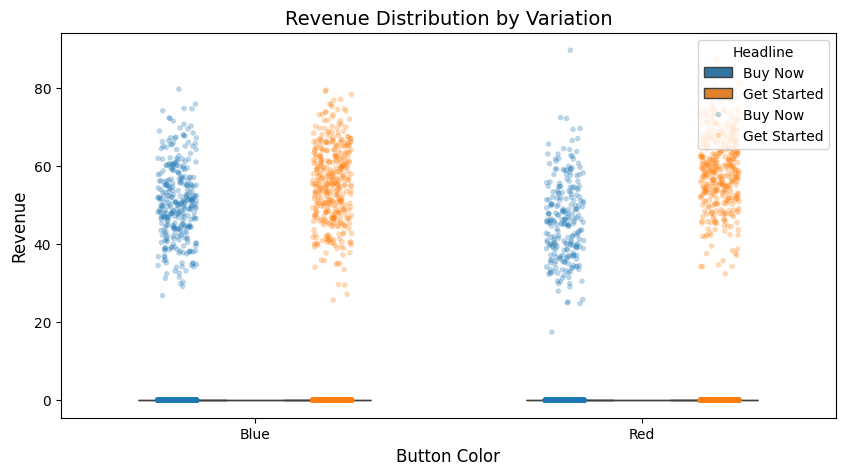

In [72]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='Button_Color', y='Revenue', hue='Headline', data=df, width=0.6, showfliers=False)
sns.stripplot(x='Button_Color', y='Revenue', hue='Headline', data=df, 
              dodge=True, jitter=True, alpha=0.3, marker='o', size=4)

plt.title('Revenue Distribution by Variation', fontsize=14)
plt.xlabel('Button Color', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.legend(title='Headline', loc='upper right')

plt.show()


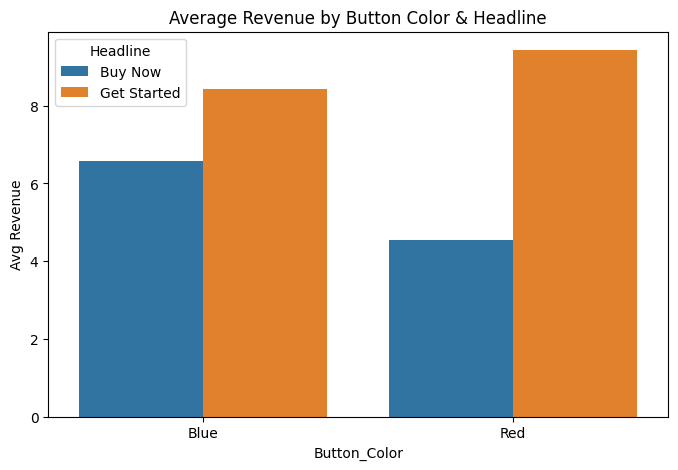

In [75]:
# Aggregate revenue by variation
avg_revenue = df.groupby(['Button_Color', 'Headline'])['Revenue'].mean().reset_index()

# Convert back to labels for plotting
avg_revenue['Button_Color'] = avg_revenue['Button_Color'].map({0: 'Blue', 1: 'Red'})
avg_revenue['Headline'] = avg_revenue['Headline'].map({0: 'Buy Now', 1: 'Get Started'})

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Button_Color", y="Revenue", hue="Headline", data=avg_revenue)
plt.title("Average Revenue by Button Color & Headline")
plt.ylabel("Avg Revenue")
plt.show()


### Step 2: ANOVA to Compare Revenue Across Variations

In [74]:
# Convert categorical variables to numeric
df['Button_Color'] = df['Button_Color'].map({'Blue': 0, 'Red': 1})
df['Headline'] = df['Headline'].map({'Buy Now': 0, 'Get Started': 1})

# Add interaction term
df['Interaction'] = df['Button_Color'] * df['Headline']

# Linear regression model
model = smf.ols("Revenue ~ Button_Color + Headline + Interaction", data=df).fit()

# Display results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     33.38
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           1.85e-21
Time:                        17:29:03   Log-Likelihood:                -43467.
No. Observations:               10000   AIC:                         8.694e+04
Df Residuals:                    9996   BIC:                         8.697e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.5725      0.374     17.566   

### Understanding Regression Results
- Intercept: Baseline revenue for the reference group (Blue + Buy Now).
- Button_Color coefficient: Change in revenue when using Red instead of Blue.
- Headline coefficient: Change in revenue when using Get Started instead of Buy Now.
- Interaction coefficient: Additional effect when Red + Get Started are used together.